# Erzeugung von Zufallszahlen

## Normalverteilte Zufallszahlen

In [1]:
import numpy

In [2]:
!pip install numpy

In [11]:
A = numpy.random.normal(loc=0.0, scale=1.0, size=10000)

In [12]:
A[:10]

array([-1.56669686, -0.24350898,  1.1499306 ,  0.64031271, -1.3104449 ,
       -2.6674762 ,  1.76917861, -0.31524475,  1.51404834,  0.63434226])

In [13]:
A.shape

(10000,)

In [14]:
A.ndim

1

In [15]:
numpy.mean(A)

np.float64(0.011263889792106843)

In [16]:
numpy.std(A)

np.float64(1.0079939572338423)

In [18]:
numpy.min(A)

np.float64(-3.7373144399406573)

In [19]:
numpy.max(A)

np.float64(3.7923895808727663)

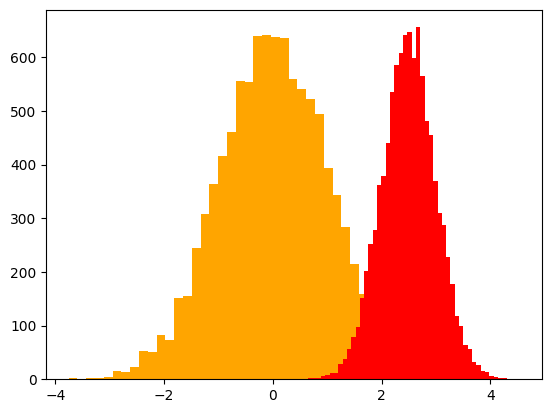

In [25]:
import matplotlib.pyplot as plt
A = numpy.random.normal(loc=0.0, scale=1.0, size=10000)
B = numpy.random.normal(loc=2.5, scale=0.5, size=10000)
plt.hist(A, bins=50, color="orange")
plt.hist(B, bins=50, color="red")
plt.show()

## Gleichverteilte Zufallszahlen

In [34]:
[numpy.random.randint(low=-3, high=+3) for _ in range(10)]

[-1, -2, 0, 1, -3, -1, -1, -2, -3, 0]

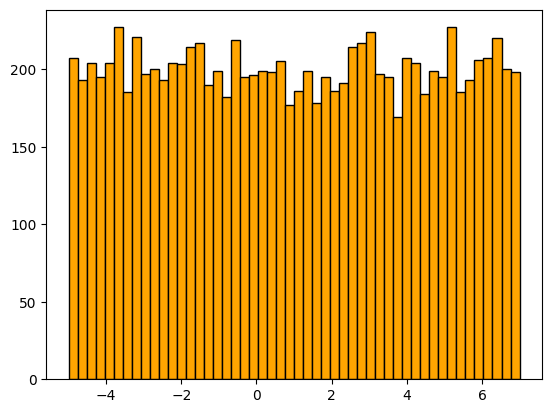

In [40]:
import matplotlib.pyplot as plt
A = numpy.random.uniform(low=-5.0, high=+7.0, size=10000)
plt.hist(A, bins=50, color="orange", edgecolor="black")
plt.show()

# Einen Sensor simulieren

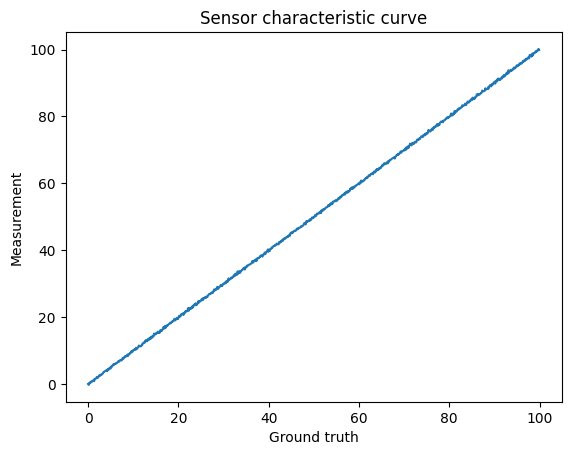

In [3]:
import numpy as np
import matplotlib.pyplot as plt

class Sensor:

    def __init__(self, variance):
        self.variance = variance

    def measure(self, ground_truth):
        noise = np.random.normal(loc=0.0, scale=self.variance)
        measurement = ground_truth + noise
        return measurement

    def measure_many(self, ground_truth, N):
        measurements = [self.measure(ground_truth) for _ in range(N)]
        return measurements

    def show_characteristic_curve(self, start, end, step=0.1):
        ground_truths = []
        measurements = []
        for ground_truth in np.arange(start,end,step):
            ground_truths.append( ground_truth )
            measurements.append( self.measure(ground_truth) )
            
        plt.plot(ground_truths, measurements)
        plt.title("Sensor characteristic curve")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement")
        plt.show()

    def __str__(self):
        return f"Distance sensor: variance={self.variance:.2f}"

    def __repr__(self):
        return str(self)
    

s1 = Sensor(0.2)
s2 = Sensor(0.5)
s3 = Sensor(1.5)

t = 50.0
N = 10

m1 = s1.measure_many(ground_truth=t, N=N)
s1.show_characteristic_curve(start=0.0, end=100.0)

In [53]:
m1

[49.88646597848392,
 49.819964360872696,
 50.22114253282569,
 49.83712061874503,
 49.88381554769503,
 50.23098300840213,
 49.764882236859634,
 50.064087461631665,
 50.31477678759238,
 49.86232174635195]

# Sensordatenfusion mittels Mittelwertschätzer

In [54]:
nr_sensors = 3
variance = 1.0
sensors = [Sensor(variance) for _ in range(nr_sensors)]

In [55]:
len(sensors)

3

In [56]:
sensors

[Distance sensor: variance=1.00,
 Distance sensor: variance=1.00,
 Distance sensor: variance=1.00]

In [59]:
gt = 50.0
multiple_measurements = [sensor.measure(gt) for sensor in sensors]
multiple_measurements

[50.45186327872361, 50.35577226079486, 48.381768071259366]

In [71]:
variance

1.0

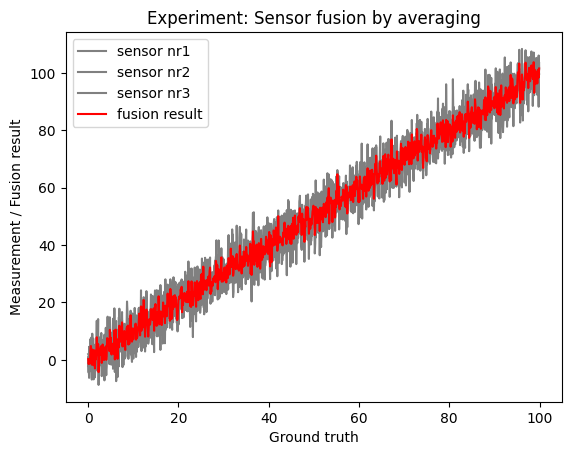

In [73]:
import numpy as np
import matplotlib.pyplot as plt

class SensorFusionAvg:

    def __init__(self, nr_sensors, variance):        
        self.nr_sensors = nr_sensors
        self.variance = variance
        self.sensors = [Sensor(variance) for _ in range(nr_sensors)]

    def measure_and_fuse(self, gt):
        measurements = [sensor.measure(gt) for sensor in self.sensors]
        avg = sum(measurements) / len(measurements)
        return measurements, avg

    def experiment(self, start, end, step=0.1):
        measurements_over_time = []
        fusion_results = []
        ground_truths = []
        for ground_truth in np.arange(start,end,step):
            measurements, avg = self.measure_and_fuse(ground_truth)
            ground_truths.append( ground_truth )
            measurements_over_time.append( measurements )
            fusion_results.append( avg )
        
        for sensor_nr in range(self.nr_sensors):
            meas_for_sensor = [v[sensor_nr] for v in measurements_over_time]
            plt.plot( ground_truths, meas_for_sensor,
                      label=f"sensor nr{sensor_nr+1}",
                      color="gray")
        plt.plot(ground_truths, fusion_results, label="fusion result", color="red")
        plt.title("Experiment: Sensor fusion by averaging")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement / Fusion result")
        plt.legend()
        plt.show()

f1 = SensorFusionAvg(nr_sensors=3, variance=5)
f1.experiment(start=0.0, end=100.0)

# Sensordatenfusion mittels IVW-Schätzer

In [17]:
import numpy as np
np.random.uniform(low=0, high=5)

4.013438838812034

In [27]:
int(np.argmin(np.array([2.4, 0.3, 9.4, 0.2, 2.5])))

3

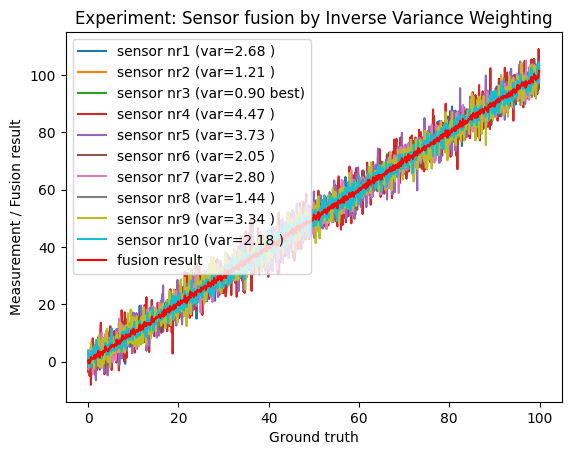

In [62]:
import numpy as np
import matplotlib.pyplot as plt

class SensorFusionIVW:

    def __init__(self, nr_sensors, max_variance):        
        self.nr_sensors = nr_sensors
        self.sensors = []
        self.sensor_variances = []
        for _ in range(nr_sensors):
            variance = np.random.uniform(low=0, high=max_variance)
            self.sensor_variances.append ( variance )
            self.sensors.append( Sensor(variance) )
        self.best_sensor_nr = np.argmin(np.array(self.sensor_variances))

    def measure_and_fuse(self, gt):
        measurements = []
        fusion_result = 0.0
        normalization_fac = 0.0
        for sensor in self.sensors:
            measurement = sensor.measure(gt)
            measurements.append( measurement )
            fusion_result += (1/sensor.variance) * measurement
            normalization_fac += (1/sensor.variance)
        fusion_result /= normalization_fac
    
        return measurements, fusion_result

    def experiment(self, start, end, step=0.1):
        measurements_over_time = []
        fusion_results = []
        ground_truths = []
        for ground_truth in np.arange(start,end,step):
            measurements, avg = self.measure_and_fuse(float(ground_truth))
            ground_truths.append( float(ground_truth) )
            measurements_over_time.append( measurements )
            fusion_results.append( avg )
        
        for sensor_nr in range(self.nr_sensors):
            meas_for_sensor = [v[sensor_nr] for v in measurements_over_time]
            var = self.sensors[sensor_nr].variance
            add_txt = ""
            if sensor_nr == self.best_sensor_nr:
                add_txt = "best"
            plt.plot( ground_truths, meas_for_sensor,                     
                      label=f"sensor nr{sensor_nr+1} ({var=:.2f} {add_txt})")
        plt.plot(ground_truths, fusion_results, label="fusion result", color="red")
        plt.title("Experiment: Sensor fusion by Inverse Variance Weighting")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement / Fusion result")
        plt.legend()
        plt.show()

        measurements_best_sensor = [v[self.best_sensor_nr] for v in measurements_over_time]

        return np.array(ground_truths), np.array(measurements_best_sensor), np.array(fusion_results)

f1 = SensorFusionIVW(nr_sensors=10, max_variance=5)
ground_truths, measurements_best_sensor, fusion_results = f1.experiment(start=0.0, end=100.0)

In [63]:
#        Mean Abs Errors
MAE = np.mean(abs(ground_truths - measurements_best_sensor))
MAE

np.float64(0.7012189844334672)

In [64]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ground_truths, measurements_best_sensor)

0.7012189844334672

In [65]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(ground_truths, fusion_results)

0.47472958641922763

# Sensorklasse mit Bias

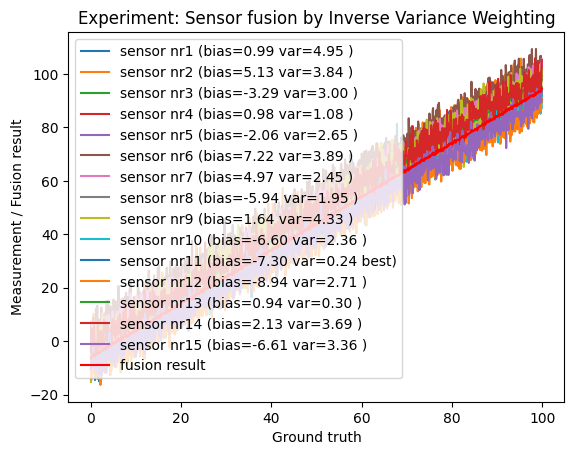

MAE= 5.86631935884305


In [100]:
import numpy as np
import matplotlib.pyplot as plt

class Sensor:

    def __init__(self, variance, bias):
        self.variance = variance
        self.bias = bias

        errors = []
        for ground_truth in np.arange(0.0,100.0,0.1):
            measurement = s1.measure(ground_truth)
            error = measurement - ground_truth
            errors.append(error)
        self.estimated_bias = np.mean( errors )

    def measure(self, ground_truth):
        noise = np.random.normal(loc=self.bias, scale=self.variance)
        measurement = ground_truth + noise
        return measurement

    def measure_many(self, ground_truth, N):
        measurements = [self.measure(ground_truth) for _ in range(N)]
        return measurements

    def show_characteristic_curve(self, start, end, step=0.1):
        ground_truths = []
        measurements = []
        for ground_truth in np.arange(start,end,step):
            ground_truths.append( ground_truth )
            measurements.append( self.measure(ground_truth) )
            
        plt.plot(ground_truths, measurements)
        plt.title("Sensor characteristic curve")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement")
        plt.show()

    def __str__(self):
        return f"Distance sensor: variance={self.variance:.2f}"

    def __repr__(self):
        return str(self)

import numpy as np
import matplotlib.pyplot as plt

np.random.seed(45)
BIAS_CORRECTION = True

class SensorFusionIVW:

    def __init__(self, nr_sensors, max_variance, max_bias):        
        self.nr_sensors = nr_sensors
        self.sensors = []
        self.sensor_variances = []
        for _ in range(nr_sensors):
            variance = np.random.uniform(low=0, high=max_variance)
            bias = np.random.uniform(low=-max_bias, high=+max_bias)
            self.sensor_variances.append ( variance )
            self.sensors.append( Sensor(variance, bias) )
        self.best_sensor_nr = np.argmin(np.array(self.sensor_variances))

    def measure_and_fuse(self, gt):
        measurements = []
        fusion_result = 0.0
        normalization_fac = 0.0
        for sensor in self.sensors:
            measurement = sensor.measure(gt)
            if BIAS_CORRECTION:
                measurement -= sensor.estimated_bias # BIAS-KORREKTUR!
            measurements.append( measurement )
            fusion_result += (1/sensor.variance) * measurement
            normalization_fac += (1/sensor.variance)
        fusion_result /= normalization_fac
    
        return measurements, fusion_result

    def experiment(self, start, end, step=0.1):
        measurements_over_time = []
        fusion_results = []
        ground_truths = []
        for ground_truth in np.arange(start,end,step):
            measurements, avg = self.measure_and_fuse(float(ground_truth))
            ground_truths.append( float(ground_truth) )
            measurements_over_time.append( measurements )
            fusion_results.append( avg )
        
        for sensor_nr in range(self.nr_sensors):
            meas_for_sensor = [v[sensor_nr] for v in measurements_over_time]
            var = self.sensors[sensor_nr].variance
            bias = self.sensors[sensor_nr].bias
            add_txt = ""
            if sensor_nr == self.best_sensor_nr:
                add_txt = "best"
            plt.plot( ground_truths, meas_for_sensor,                     
                      label=f"sensor nr{sensor_nr+1} ({bias=:.2f} {var=:.2f} {add_txt})")
        plt.plot(ground_truths, fusion_results, label="fusion result", color="red")
        plt.title("Experiment: Sensor fusion by Inverse Variance Weighting")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement / Fusion result")
        plt.legend()
        plt.show()

        measurements_best_sensor = [v[self.best_sensor_nr] for v in measurements_over_time]

        return np.array(ground_truths), np.array(measurements_best_sensor), np.array(fusion_results)

f1 = SensorFusionIVW(nr_sensors=15, max_variance=5, max_bias=10)
_,_, fusion_results = f1.experiment(start=0.0, end=100.0)

from sklearn.metrics import mean_absolute_error
MAE = mean_absolute_error(ground_truths, fusion_results)
print("MAE=", MAE)

# Sensoren mit nicht-linearer Kennlinie

In [145]:
namen = ["Brauer", "Maier", "Schulze"]
vornamen = ["Jürgen", "Egon", "Heinz"]
for i in range(len(namen)):
    print(vornamen[i], namen[i])

for vorname, name in zip(vornamen, namen):
    print(vorname, name)

Jürgen Brauer
Egon Maier
Heinz Schulze
Jürgen Brauer
Egon Maier
Heinz Schulze


In [150]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

class Sensor:

    def __init__(self, variance, bias, logfac):
        self.variance = variance
        self.bias = bias
        self.logfac = logfac

        errors = []
        for ground_truth in np.arange(0.001,100.0,0.1):
            measurement = s1.measure(ground_truth)
            error = measurement - ground_truth
            errors.append(error)
        self.estimated_bias = np.mean( errors )

    def measure(self, ground_truth):
        noise = np.random.normal(loc=self.bias, scale=self.variance)
        measurement = np.log(ground_truth)*self.logfac + noise
        return measurement

    def measure_many(self, ground_truth, N):
        measurements = [self.measure(ground_truth) for _ in range(N)]
        return measurements

    def show_characteristic_curve(self, start, end, step=0.1):
        ground_truths = []
        measurements = []
        for ground_truth in np.arange(start,end,step):
            ground_truths.append( ground_truth )
            measurements.append( self.measure(ground_truth) )
            
        plt.plot(ground_truths, measurements)
        plt.title("Sensor characteristic curve")
        plt.xlabel("Ground truth")
        plt.ylabel("Measurement")
        
    def __str__(self):
        return f"Distance sensor: variance={self.variance:.2f}"

    def __repr__(self):
        return str(self)

    def create_inverse_sensor_model(self, start, end, step=0.1):

        ground_truths = []
        measurements = []
        for ground_truth in np.arange(start,end,step):
            sum_measurements = 0.0
            N = 10
            for meas_nr in range(N):
                measurement = self.measure(ground_truth)
                sum_measurements += measurement
            avg_measurement_val = sum_measurements/N
            ground_truths += [ground_truth]
            measurements += [avg_measurement_val]

        d = {"Messwert" : measurements,
             "Entfernung" : ground_truths}

        self.ism = pd.DataFrame(d)
        return self.ism

    def map_sensor_value_to_distance(self, sensor_val):
        distances = abs(self.ism["Messwert"] - sensor_val)
        row_idx = distances.idxmin()
        return self.ism["Entfernung"].iloc[row_idx]
        

# N Sensoren simulieren
sensors = [Sensor(0.1,3,10),
           Sensor(1.0,-4,20),
           Sensor(1.2,-10,40)]

# Für jeden Sensor das Inverse Sensor Modell aufbauen
for sensor in sensors:
    sensor.create_inverse_sensor_model(0.01, 100.0)

# Eine Messung simulieren
gt = 50.3
measurements = [sensor.measure(gt) for sensor in sensors]

# Nutze das ISM, um die Messwerte auf Distanzschätzungen abzubilden
distances = [s.map_sensor_value_to_distance(v) for s,v in zip(sensors, measurements)]

In [151]:
measurements

[np.float64(42.19712606156253),
 np.float64(74.12103015283327),
 np.float64(146.72218986343913)]

In [152]:
distances

[np.float64(50.31), np.float64(50.71), np.float64(49.81)]

In [122]:
t

,Messwert,Entfernung
0,-44.976275,0.01
1,-19.833446,0.11
2,-13.617874,0.21
3,-10.658199,0.31
4,-8.299449,0.41
...,...,...
995,45.413203,99.51
996,47.715942,99.61
997,46.284115,99.71
998,45.470010,99.81


In [133]:
distances = abs(t["Messwert"] - 15.0)
distances

0      59.976275
1      34.833446
2      28.617874
3      25.658199
4      23.299449
         ...    
995    30.413203
996    32.715942
997    31.284115
998    30.470010
999    32.062245
Name: Messwert, Length: 1000, dtype: float64

In [135]:
distances.idxmin()

42

In [136]:
distances.iloc[42]

np.float64(0.21290376688252444)

In [137]:
t.iloc[42]

Messwert      15.212904
Entfernung     4.210000
Name: 42, dtype: float64